# Model proto

This is a rough prototype of our RL solution

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os
from collections import Counter

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.dnd.game_board import DnDBoard
from src.agent.agent import DnDAgent
from src.agent.agent_utils import get_legal_action_resolver, get_states, self_play_loop
from src.agent.training import train_loop_trivial

In [3]:
seed_everything(1234)

## Sample agent game

In [4]:
def custom_reward(game, unit: Unit, player_id: int, move_legal: bool, action_legal: bool, updates: dict):
        units_removed = updates['units_removed']
        reward = -0.05
        game_over = False
        # reward for removing enemy units, 1 for each unit
        reward += len([x for x in units_removed if x[1] != player_id])
        # reward for defeating players
        reward += 5 * len([x for x in units_removed if len(game.players_to_units[x[1]]) == 0 and x[1] != player_id])
        # reward for winning
        if len(game.players_to_units[player_id]) == len(game.units):
            game_over = True
            reward += 10
        # penalty for losing (on your own turn ??)
        if len(game.players_to_units[player_id]) == 0:
            game_over = True
            reward = -10
        
        return reward, game_over

In [ ]:
def decorate_game(game: DnDBoard, 
                  rename_units: bool=True, 
                  make_colormap: bool=True, 
                  player_names: list[str]=['Ally', 'Enemy'],
                  player_colors: list[list[str]]=[['Green', 'Blue', 'Cyan'], ['Red', 'Purple', 'Orange']]):
    colormap = {}
    color_index = 0
    
    if player_colors is None: player_colors = []
    for units, player_name, colors in zip_longest(game.players_to_units.values(), player_names, player_colors):
        names_to_units = {}
        for unit in units:
            if unit.name not in names_to_units: names_to_units[unit.name] = []
            names_to_units[unit.name].append(unit)
        
        if make_colormap:
            names_to_color = {}
            if colors is not None: color_index = 0
            if colors is None: colors = list(CCOLORS)
            for name in names_to_units:
                names_to_color[name] = colors[color_index]
                color_index = (color_index + 1) % len(colors)
            
            for unit in units: colormap[unit] = names_to_color[unit.name]

        if rename_units:
            for name in names_to_units:
                for index, unit in enumerate(names_to_units[name], 1):
                    unit.name = f'{player_name} {name}'
                    if len(names_to_units[name]) > 1:
                        unit.name += f' {index}'
    
    if make_colormap:
        return game, colormap
    
    return game

In [6]:
# next state is delayed and can be inconsistent. Enemy reward is your punishment
def train_loop_delayed(agent: DnDAgent, game: DnDBoard) -> int:
    game_over = False
    iter_count = 0
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_count += 1
    
        state, action_vector, new_coords, action = get_states(game, agent)
        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_vector, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_action = action_vector
        last_reward = reward

    return iter_count

In [ ]:
board_size = (8, 8)
game_config = [
    (GenericSoldier('Soldier', attack_damage=25), 1),
    (GenericSoldier('Archer', health=50, attack_damage=25, speed=4, range=8), 1)
]

In [7]:
agent = DnDAgent(board_shape=board_size, in_channels=8, out_actions=2, 
    lr=1e-3, 
    epsilon=0.1, 
    min_epsilon=0.01,
    epsilon_delta=1e-5, 
    epsilon_strategy='linear',
    gamma=0.9,
    batch_size=32, 
    dual_learning=True, 
    replace_model_interval=5000,
    memory_capacity=100000,
    random_action_resolver=get_legal_action_resolver(board_size)
)

train_loop = train_loop_trivial
reward_policy = None

In [8]:
reports_path = None #'../config-log/2v2-0/'
generation_name = 'gen31'
gen_header = \
'''# ???
'''

In [9]:
iters, eps, checkpoints, reps = [], [], [], []
mag1s, mag2s = [], []

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace

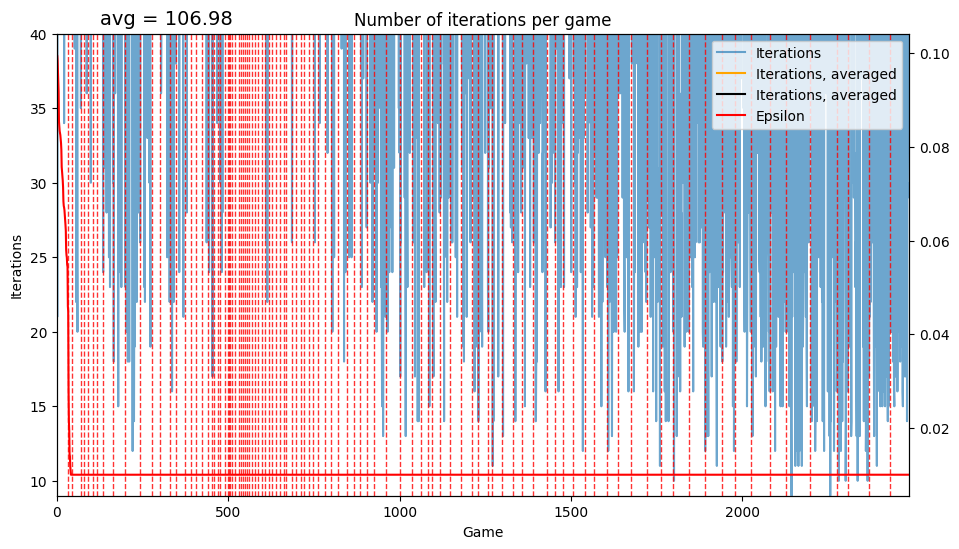

Training:  12%|#2        | 2487/20000 [1:10:49<2:40:26,  1.82it/s, mag1=8.38, mag2=7.09]

In [10]:
games = 20000
checkpoint_each = 4000
checkpoint_name = f'2v2-0-agent-{generation_name}'
if checkpoint_name is None: checkpoint_each = 1e99
last_update = time.time()

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = generate_balanced_game(board_size, game_config, reward_head=reward_policy)
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        iter_count = train_loop(agent, game)
        iters.append(iter_count)
        eps.append(agent.epsilon)
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        ctime = time.time()
        if ctime - last_update > 20:
            clear_output(wait=True)
            plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=40)
            display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_each:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-1000:]) # recent performance
            agent.save_agent(f'../checkpoints/{checkpoint_name}-{avg:0.1f}i-{iter_i}')

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)

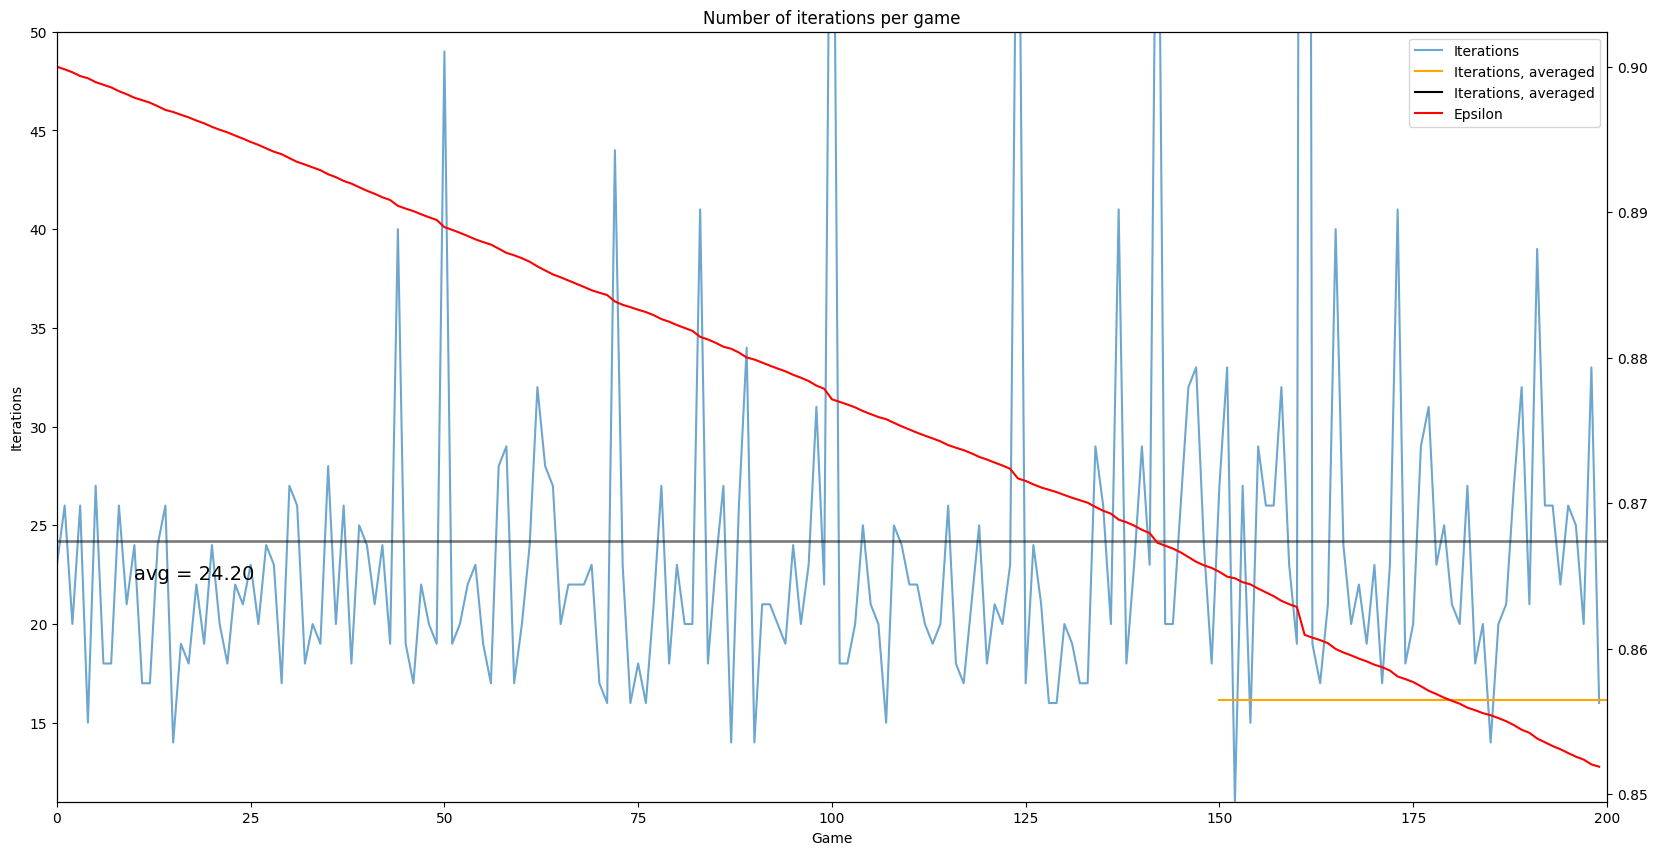

In [ ]:
plot_training_history(iters, eps, checkpoints, vlines=reps, ylim=50, figsize=(20, 10), show=False)
if reports_path is not None:
    export_path = os.path.join(reports_path, generation_name)
    os.makedirs(export_path)
    plt.savefig(os.path.join(export_path, 'training.png'), bbox_inches='tight')
plt.show()

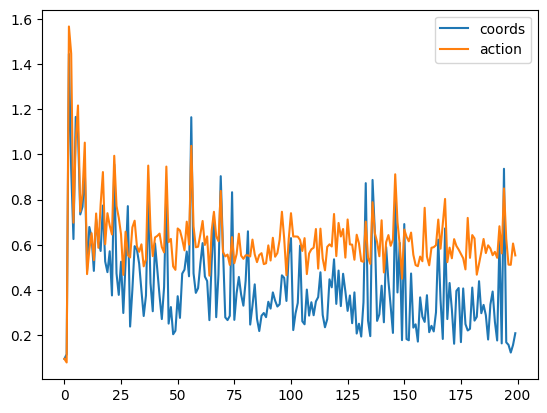

Total number of iterations: 4841


In [ ]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()
if reports_path is not None:
    plt.savefig(os.path.join(export_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [ ]:
if reports_path is not None:
    with open(os.path.join(export_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
    f'''{gen_header}
    # Results
    ![image](training.png "")
    
    * Average iteration count after 20k games: {avg:0.2f}
    * Total iterations performed: {total}
    * Relative training performance: {perf:0.2f}
    > 1e9 / (total_iter * avg_iter)
    
    ## Model's outputs magnitude history:
    
    ![magnitudes](magnitude.png "")
    ''')

In [ ]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

Shortest game: 11
Longest game: 192
Number of shortest games: 1


In [ ]:
game, color_map = create_same_game(board_size)

self_play_loop(agent, game, color_map, reset_epsilon=True, delay=1)

Iteration: 19
Turn made by player #0: `Ally archer`:
	Unit moves: (7, 6) -> (0, 7);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally archer', 'target_unit': 'None'}

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0     ██           0 
 1                  1 
 2                  2 
 3 ██               3 
 4                  4 
 5               ██ 5 
 6                  6 
 7             ██   7 
    0 1 2 3 4 5 6 7

Next move is by player #1: `Enemy soldier`

Game interrupted after 20 iterations


# Visualization

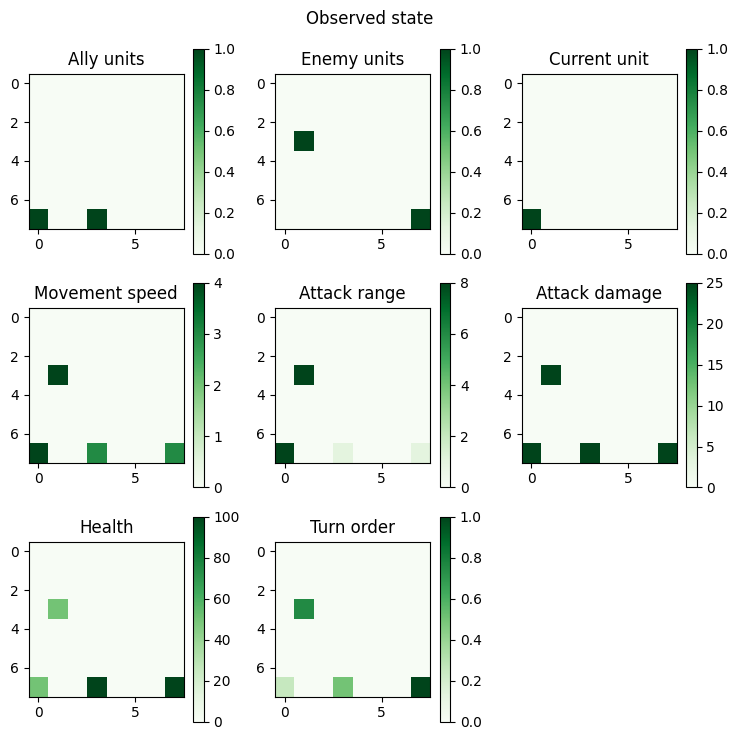

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [ ]:
game, color_map = create_same_game(board_size)
print_game(game, color_map)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0                  0 
 1     ██           1 
 2                  2 
 3         ██       3 
 4                  4 
 5                  5 
 6                  6 
 7 ██        ██     7 
    0 1 2 3 4 5 6 7

Next move is by player #1: `Enemy soldier`


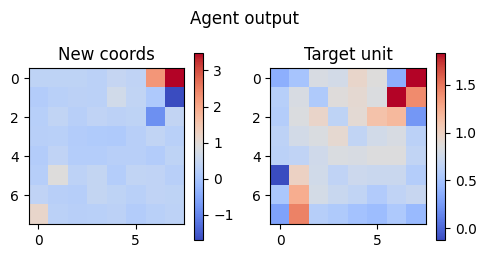

[[1, 7], [3, 5]]


In [ ]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))